In [1]:
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import torch.nn.functional as F
from tqdm.notebook import tqdm
import math
from IPython.display import clear_output
from gymnasium.wrappers import AtariPreprocessing

https://www.youtube.com/watch?v=IAaUXszVT_A&ab_channel=ImprobableAI

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    

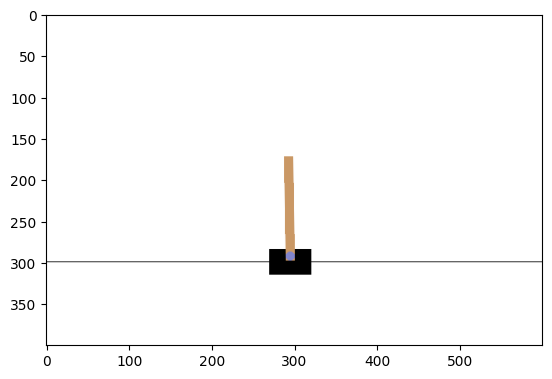

In [4]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [5]:
class Dist_DQN(nn.Module):
    def __init__(self,n_states,n_actions,n_atoms = 51):
        super(Dist_DQN,self).__init__()
        self.n_atoms = n_atoms
        self.n_actions = n_actions
        self.l_1 = nn.Linear(n_states,64)
        self.l_2 = nn.Linear(64,64)
        self.l_3 = nn.Linear(64,self.n_actions*self.n_atoms)
        
    def forward(self,x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.l_2(x))
        #x = self.l_3(x)
        #x = F.softmax(x.view(length_x,self.n_actions,self.n_atoms),dim=2)
        x = F.softmax(self.l_3(x).view(-1,self.n_atoms),dim=-1)
        x = x.view(-1,self.n_actions,self.n_atoms)
        return x
        

In [7]:
Q = Dist_DQN(4,2).to(device)
static_Q = Dist_DQN(4,2).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [8]:
Vmin = -10
Vmax = 10
num_atoms = 51

In [9]:
def select_action(state,epsilon = 1e-6,vmin=-10,vmax=10,num_atoms=51):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        dist = Q(state)
        dist = dist.data.cpu() * torch.linspace(vmin,vmax,num_atoms)
        action = torch.argmax(dist.sum(-1),dim=1).item()
        return action

In [10]:
def projection_dist(next_state,rewards,dones):
    with torch.inference_mode():
        batch_size = next_state.shape[0]
    
        delta_z = float(Vmax-Vmin) / (num_atoms - 1)
        support = torch.linspace(Vmin,Vmax,num_atoms)
    
        next_dist = static_Q(next_state).data.cpu() * support
        next_action = torch.argmax(next_dist.sum(-1),dim=1)
        next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
        next_dist   = next_dist.gather(1, next_action).squeeze(1)
    
        rewards = rewards.unsqueeze(dim=1).expand_as(next_dist)
        dones = dones.unsqueeze(dim=1).expand_as(next_dist)
        support = support.unsqueeze(dim=0).expand_as(next_dist)
    
        Tz = rewards + dones * 0.99 * support
        Tz = Tz.clamp(Vmin,Vmax)
        b = (Tz-Vmin) / delta_z
        l = b.floor().long()
        u = b.ceil().long()
    
        offset = torch.linspace(0,(batch_size-1) * num_atoms,batch_size).long().unsqueeze(dim=1).expand(batch_size,num_atoms)
    
        proj_dist = torch.zeros(next_dist.size())
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
        proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
    
    return proj_dist

In [14]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 6000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [12]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 2e-4,start_train_at = 10000,avg_reward_for_solved=450,averaging_last=100):

    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon,vmin=Vmin,vmax=Vmax)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > start_train_at:
            s,action,reward,next_state,done = replay_buffer.get_batch()
            
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done))
            
            proj_dist = projection_dist(next_state,reward.cpu(),not_done)
            proj_dist = proj_dist.to(device)
            
            dist = Q(s)
            action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
            dist = dist.gather(1,action).squeeze(dim=1)
            dist.data.clamp_(0.01,0.99)
            
            loss = -(proj_dist * dist.log()).sum(1).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if t % 100 == 0:
                static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-averaging_last:]) > avg_reward_for_solved:
            print('Solved')
            break
        if t % 1000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

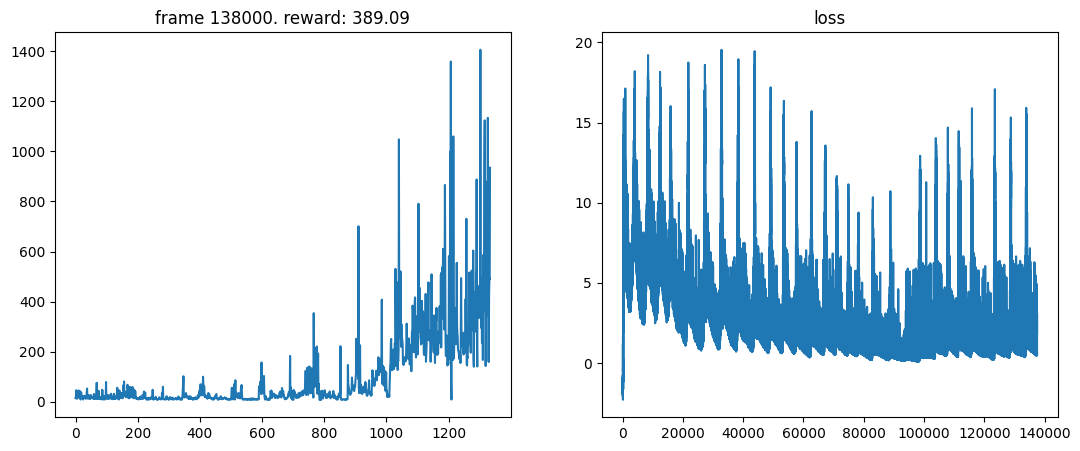

epsilon 0.01
Solved


In [172]:
train(Q,static_Q,1000000,env,batch_size=8,replay_buffer_size=10000,gamma=0.99,lr=1e-4,avg_reward_for_solved=400,averaging_last=100,start_train_at=500)

# Quantile regression

In [5]:
class Dist_DQN(nn.Module):
    def __init__(self,n_states,n_actions,n_q=51):
        super(Dist_DQN,self).__init__()
        self.n_q = n_q
        self.n_actions = n_actions
        self.l_1 = nn.Linear(n_states,64)
        self.l_2 = nn.Linear(64,64)
        self.l_3 = nn.Linear(64,self.n_actions*self.n_q)
        
    def forward(self,x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.l_2(x))
        x = self.l_3(x)
        x = x.view(x.shape[0],self.n_actions,self.n_q)
        return x
    
    def q_values(self,x):
        x = self.forward(x)
        return x.mean(-1)

In [6]:
Q = Dist_DQN(4,2).to(device)
static_Q = Dist_DQN(4,2).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [9]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        q_val = Q(state).mean(-1)
        action = torch.argmax(q_val,dim=1).item()
        return action

In [10]:

n_quant = 51

In [11]:
def projection_dist(dist,next_state,rewards,dones):
    with torch.inference_mode():
        batch_size = next_state.shape[0]
        next_dist = static_Q(next_state)
        next_action = torch.argmax(next_dist.mean(2),dim=1)
        next_action = next_action.unsqueeze(dim=1).unsqueeze(dim=1).expand(batch_size,1,n_quant)
        next_dist = next_dist.gather(1,next_action).squeeze(dim=1).cpu().detach()
    
        expected_quant = rewards.unsqueeze(dim=1) + 0.99 * next_dist * dones.unsqueeze(dim=1)
    
        quant_idx = torch.sort(dist,1,descending=False)[1]
    
        tau_hat = torch.linspace(0.0,1.0-1./n_quant,n_quant) + 0.5 / n_quant
        tau_hat = tau_hat.unsqueeze(dim=0).repeat(batch_size,1)
        quant_idx = quant_idx.cpu().detach()
        batch_idx = np.arange(batch_size)
        tau = tau_hat[:, quant_idx][batch_idx,batch_idx]
    return tau,expected_quant

In [16]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 2e-4,start_train_at = 10000,avg_reward_for_solved=450,averaging_last=100):
    Q.train()
    static_Q.eval()
    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > start_train_at:
            s,action,reward,next_state,done = replay_buffer.get_batch()
            
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward)
            next_state = torch.from_numpy(next_state).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done))
            
            dist = Q(s)
            action = action.unsqueeze(dim=1).unsqueeze(dim=1).expand(batch_size,1,n_quant)
            dist = dist.gather(1,action).squeeze(dim=1)
            
            tau,expected_quant = projection_dist(dist,next_state,reward,not_done)
            k = 1
            #print(expected_quant.t().shape,dist.shape)
            u = expected_quant - dist.cpu()
            huber_loss = 0.5 * u.abs().pow(2)
            huber_loss += k*(u.abs() - u.abs().clamp(min=0.0,max = k))
            quantile_loss = (tau-(u < 0).float()).abs() * huber_loss
            loss = quantile_loss.sum()/ n_quant            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if t % 100 == 0:
                static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-averaging_last:]) > avg_reward_for_solved:
            print('Solved')
            break
        if t % 1000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

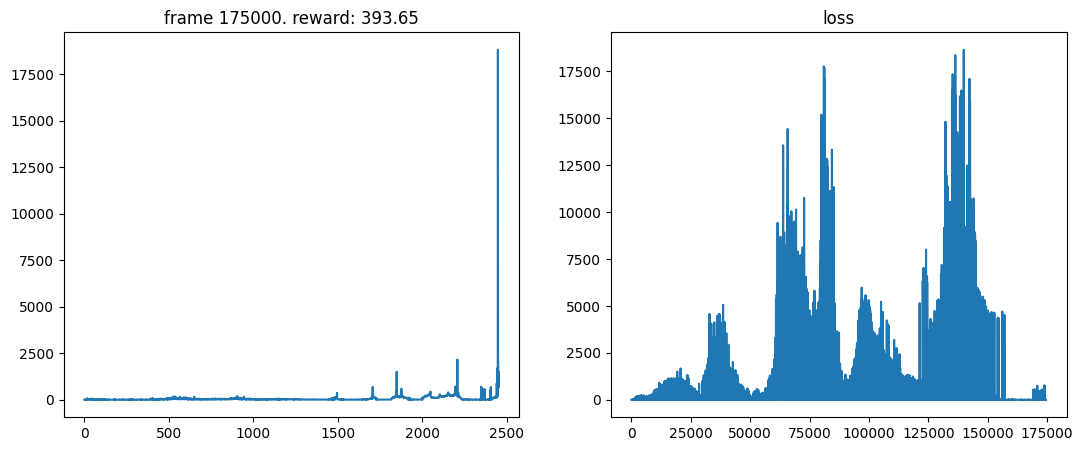

epsilon 0.01
Solved


In [17]:
train(Q,static_Q,1000000,env,batch_size=8,replay_buffer_size=10000,gamma=0.99,lr=1e-4,avg_reward_for_solved=400,averaging_last=100,start_train_at=500)

In [18]:
# env_2 = gym.make('CartPole-v1',render_mode = 'human')
# #env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         action = select_action(state,epsilon=0)
#         next_state,reward,done,_,info = env_2.step(action)
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()

rewad 1004.0
rewad 997.0
rewad 1764.0
rewad 894.0
rewad 1702.0
